## Quantum Cryptography & Security: lab report 02 - QKD IR

## Imports & Google Drive mount

In [ ]:
!pip install numba

In [ ]:
import copy as cp
import heapq
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import warnings
import os
import seaborn as sns
import time
import warnings
from abc import ABC, abstractmethod
from google.colab import files as gc_files
from numpy import zeros, ceil, floor, copy, mean, sign
from numba import jit
from numba.core.errors import NumbaPendingDeprecationWarning
from os import path
from scipy.sparse import dok_matrix as sparse_matrix
from scipy.sparse import find as sparse_find

In [ ]:
# Filter out specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

In [ ]:
# This script would mount the drive onto the Colab Notebook
# If there is a drive mounted, the notebook would return:
# "Mounted at /content/drive" or "Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True)"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to experimental data
data_path = "/content/drive/My Drive/QCS-Lab-02-QKD-IR-Data/"

## LDPC-based error correction

## Helper functions

In [ ]:
# file_utils.py
def lines_to_array(lines):
    return [list(map(int, x.split(' '))) for x in lines]

def codes_from_file(file_path):
    with open(file_path, 'r') as fp:
        data = fp.read()
        lines = data.split('\n')
        start_read_index = 0
        result = dict()
        # 4 here because last entry must have at least 5 lines (1 for meta, 1 for s_y_joins, 1 for y_s_joins and 2 blank lines)
        while start_read_index < len(lines) - 4:
            R, frame_len, syndrome_len = lines[start_read_index].split(' ')
            R = float(R)
            frame_len = int(frame_len)
            syndrome_len = int(syndrome_len)
            begin_s_y_joins_index = start_read_index + 1
            end_s_y_joins_index = begin_s_y_joins_index + syndrome_len
            s_y_joins = lines_to_array(lines[begin_s_y_joins_index:end_s_y_joins_index])
            begin_y_s_joins_index = end_s_y_joins_index
            end_y_s_joins_index = begin_y_s_joins_index + frame_len
            y_s_joins = lines_to_array(lines[begin_y_s_joins_index:end_y_s_joins_index])
            begin_punct_list_index = end_y_s_joins_index
            end_puct_list_index = begin_punct_list_index + 1
            punct_list = lines_to_array(lines[begin_punct_list_index:end_puct_list_index])
            result[(R, frame_len)] = {
                'R': R,
                'frame_len': frame_len,
                'syndrome_len': syndrome_len,
                's_y_joins': s_y_joins,
                'y_s_joins': y_s_joins,
                'punct_list': punct_list[0]
            }
            start_read_index = end_puct_list_index + 1
        return result

## Error correction library

In [ ]:
# error_correction_lib.py
def generate_key(length):
    """
    Generate random key of length 'length'
    """
    return np.random.randint(0, 2, (1, length))[0]

def generate_key_zeros(length):
    """
    Generate key with zeors only of length 'length'
    """
    return np.zeros(length, dtype=np.int64)

def add_errors(a, error_prob):
    """
    Flip some values (1 -> 0, 0 -> 1) in 'a' with probability 'error_prob'
    """
    error_mask = np.random.choice(2, size=a.shape, p=[1.0 - error_prob, error_prob])
    return np.where(error_mask, ~a+2, a)

def add_errors_prec(a, error_prob):
    """
    Add precisely 'error_prob' * length('a') errors in key 'a'
    """
    len_a = len(a)
    n_er = int(round(len_a * error_prob))
    list_1 = list(range(0, len_a))
    list_2 = random.sample(list_1, n_er)
    K_cor = a.copy()
    for i in list_2:
        K_cor[i] = 1 - K_cor[i]
    return K_cor

@jit(nopython=True, nogil=True, cache=True)
def h_b(x):
    """
    Binary entropy function of 'x'
    """
    if x > 0:
        return - x * np.log2(x) - (1-x) * np.log2(1-x)
    elif x == 0:
        return 0
    else:
        print("Incorrect argument in binary entropy function!")

@jit(nopython=True,nogil=True,cache=True)
def choose_sp(qber, f, R_range, n):
    '''
    Choose appropriate rate and numbers of shortened and punctured bits
    '''
    def get_sigma_pi(qber, f, R):
        pi = (f * h_b(qber) - 1 + R) / (f * h_b(qber) - 1) # pi = ratio of punctured bits
        sigma = 1 - (1 - R) / f / h_b(qber) # sigma = ratio of shortened bits
        return max(0, sigma), max(0, pi)
    delta_min = 1
    R_min = None
    for R in R_range:
        sigma_c, pi_c = get_sigma_pi(qber, f, R)
        delta_c = max(sigma_c, pi_c)
        if delta_c < delta_min:
            delta_min = delta_c
            sigma_min = sigma_c
            pi_min = pi_c
            R_min = R
    if R_min is not None:
        return R_min, int(floor(n * sigma_min)), int(ceil(n * pi_min))

def generate_sp(s_n, p_n, k_n, p_list=None):
    '''
    Generates 's_n', 'p_n' and 'k_n' positions of shortened ('s_pos'), punctured ('p_pos') and key ('k_pos') symbols correspondingly.
    Punctured symbols are taken from 'p_list' if it is not None.
    If it is 'p_list' is None of 'p_n' is larger than number of elements in 'p_list', then they are token from the whole key.
    '''
    n = k_n + s_n + p_n # length of total key
    all_pos = list(range(int(n))) # array of all indices
    if p_list is None:
        punct_list = all_pos
    elif p_n <= len(p_list):
        punct_list = p_list
    else:
        punct_list = all_pos # taking all positions if it not enough elements in p_list
    if p_n > len(punct_list):
        print('Error with dimensions p_n =', p_n, 'but length of punct_list is', len(punct_list))
    p_pos = np.sort(random.sample(punct_list, p_n))
    all_pos_tmp = np.setdiff1d(all_pos, p_pos)
    s_pos = np.sort(random.sample(list(all_pos_tmp), s_n))
    k_pos = np.setdiff1d(all_pos_tmp, s_pos)
    return s_pos, p_pos, k_pos

def extend_sp(x, s_pos, p_pos, k_pos):
    '''
    Construct extended key 'x' with shortened/punctured/key bits in positions 's_pos'/'p_pos'/'k_pos'
    '''
    k_n = len(k_pos)
    s_n = len(s_pos)
    p_n = len(p_pos)
    if len(x) != len(k_pos):
        print("Error with dimensions in key and k_pos!")
    n = k_n + s_n + p_n # length of extended key
    x_ext = generate_key(n)
    if s_n > 0:
        x_ext[s_pos] = 0
    if p_n > 0:
        x_ext[p_pos] = generate_key(p_n)
    x_ext[k_pos] = x
    return x_ext

def encode_syndrome(x, s_y_joins):
    """
    Encode vector 'x' with sparse matrix, characterized by 's_y_joins' (matrix multiplication mod 2)
    """
    m = len(s_y_joins)
    s = generate_key_zeros(m)
    for k in range(m):
        s[k] = (sum(x[s_y_joins[k]]) % 2)
    return np.array(s)

# LLR --> Log-Likelihood Ratio
def decode_syndrome_minLLR(y, s, s_y_joins, y_s_joins, qber_est, s_pos, p_pos, k_pos, r_start=None, max_iter=300, x=None, show=1, discl_n=20, n_iter_avg_window=5):
    """
    INPUT:
      - 'y' is decoding vector.
      - 's' is syndrome.
      - 's_y_joins' and 'y_s_joins' is parity-check matrix information.
      - 'qber_est' is an estimated level of QBER.
      - 's_pos'/'p_pos'/'k_pos' stands for positions of shortened/punctured/key bits.
      - 'r_start' is vector of predefined LLRs.
      - 'max_iter' is maximal number of iterations in the general cycle.
      - 'x' is true vecotor decoding vector (for comparison and check of decoding convergence).
      - 'show' is parameter for additional output: 1 -- output of decoding results, 2 -- output for each iteration.
      - 'discl_n' is number of bits disclosed in each additional communication round.
      - 'n_iter_avg_window' is number of iterations for mean LLR averaging for the stop of procedure
    OUTPUT:
      - 'z' -- decoded vector.
      - 'minLLR_inds' -- indices of symbols with minimal LLRs.
    """

    def h_func(x, mode=0):
        """
        Approximation of log(np.abs(np.exp(x) - 1)) for 'mode'= 0
        """
        if mode == 0:
            if x < -3:
                return 0
            elif x < -0.68:
                return -0.25*x - 0.75
            elif x < -0.27:
                return -2*x - 1.94
            elif x < 0:
                return -8*x - 3.56
            elif x < 0.15:
                return 16*x - 4
            elif x < 0.4:
                return 4*x - 2.2
            elif x < 1.3:
                return 2*x - 1.4
            else:
                return x - 0.1
        else:
            return np.log(np.abs(np.exp(x)-1))

    @jit(nopython=True,nogil=True,cache=True)
    def core_func(x, y, mode=2):
        '''
        Core function () for computation of LLRs.
        'x' and 'y' are arguments.
        'mode' is approximation method: 0 - piecewise, 1 - table, 2 - exact.
        '''

        def g_func_piecewise(x):
            """
            Approximation of log(1 + exp(-x)) by linear interpolation between points
            """
            if x < 0.5:
                return -x/2 + 0.7
            elif x < 1.6:
                return -x/4 + 0.575
            elif x < 2.2:
                return -x/8 + 0.375
            elif x < 3.2:
                return -x/16 + 0.2375
            elif x < 4.4:
                return -x/32 + 0.1375
            else:
                return 0

        def g_func_table(x):
            """
            Aproximation of log(1 + exp(-x)) by tabulated values
            """
            if x < 0.196:
                return 0.65
            elif x < 0.433:
                return 0.55
            elif x < 0.71:
                return 0.45
            elif x < 1.105:
                return 0.35
            elif x < 1.508:
                return 0.25
            elif x < 2.252:
                return 0.15
            elif x < 4.5:
                return 0.05
            else:
                return 0
        if mode == 0:
            # piecewise
            return np.sign(x) * np.sign(y) * min(abs(x), abs(y)) + g_func_piecewise(abs(x+y)) - g_func_piecewise(abs(x-y))
        elif mode == 1:
            # table
            return sign(x) * sign(y) * min(abs(x), abs(y)) + g_func_table(abs(x+y)) - g_func_table(abs(x-y))
        else:
            # exact
            return sign(x) * sign(y) * min(abs(x), abs(y))+ np.log(1 + np.exp(-abs(x+y))) - np.log(1 + np.exp(-abs(x-y)))
    if not qber_est < 0.5: # adequate QBER check
        raise ValueError('A prior error probability must be less than 1/2!')
    m = len(s_y_joins)
    n = len(y_s_joins)
    p_n = len(p_pos)
    s_n = len(s_pos)
    k_n = len(k_pos)
    v_pos = list(set(p_pos) | set(k_pos))
    # Zeroing
    M = np.zeros((m, n)) # array of messages from symbol nodes to check nodes
    sum_E_abs_mean_hist = [] # array for mean values of LLRs
    n_iter = 0 # iteration counter
    # Setting initial LLRs:
    if r_start is None:
        r = zeros(n)
        if s_n > 0:
            r[s_pos] = (1 - 2*y[s_pos]) * 1000
        if p_n > 0:
            r[p_pos] = 0
        r[k_pos] = (1 - 2*y[k_pos]) * np.log((1 - qber_est)/qber_est)
    else:
        r = r_start
        if s_n > 0:
            r[s_pos] = (1 - 2*y[s_pos]) * 1000
    for j in range(m): # setting initial messages from symbol nodes to check nodes
        M[j, :] = r
    while n_iter < max_iter: # main cycle
        # Part 1: from check nodes to symbol nodes
        # Array of messages from check nodes to symbol nodes
        E = np.zeros((m, n))
        for j in range(m): # for all check nodes
            M_cur = M[j][s_y_joins[j]]
            # All symbol nodes that are connected to current check node and their number
            M_cur_n = len(M_cur)
            n_zeros = list(M_cur).count(0.0) # number of zero LLRs
            if n_zeros > 1: # if check node is dead
                E[j, s_y_joins[j]] = np.zeros(M_cur_n) # no messages
            elif n_zeros == 1: # if current check node has one punctured symbol
                # All messages are initializrd with zeros
                E_cur = np.zeros(M_cur_n)
                M_cur = list(M_cur)
                zero_ind = M_cur.index(0.0)
                M_cur.pop(zero_ind) # excluding zero message
                LS = M_cur[0]
                for k in range(1, M_cur_n - 1): # accumulation of the message
                    LS = core_func(LS, M_cur[k])
                E_cur[zero_ind] = LS
                E[j, s_y_joins[j]] = E_cur # filling with nonzero message
            elif n_zeros == 0: # all messages are non zero
                LS = M_cur[0]
                for k in range(1, M_cur_n):
                    LS = core_func(LS, M_cur[k])
                E_cur = zeros(M_cur_n)
                for i_1 in range(0, M_cur_n):
                    # Computation of messages
                    E[j][s_y_joins[j][i_1]] = (1 - 2*s[j]) * (h_func(M_cur[i_1] + LS) - h_func(M_cur[i_1] - LS) - LS)
        # Part 2: from symbol nodes to check nodes
        # Array of sums of messages to symbol nodes (LLRs)
        sum_E = E.sum(axis=0) + r
        z = (1 - np.sign(sum_E)) / 2 # current decoded message
        if (s == encode_syndrome(z, s_y_joins)).all(): # if syndrome is correct
            if np.count_nonzero(z==x) != n:
                print("Convergence error, error positions:")
                print('\n', np.nonzero((z+x) % 2))
            if show > 0:
                print(f'done in {n_iter} iterations, matched bits: {np.count_nonzero(z==x)}/{n}')
            return z, None
        if show > 1:
            print(f'Matched bits: {np.count_nonzero(z==x)}/{n}')
            print(f'Mean LLR magnitude: {mean(abs(sum_E[v_pos]))}')
            print(f'Averaged mean LLR magnitude: {sum(sum_E_abs_mean_hist[max(0, n_iter - n_iter_avg_window): n_iter]) / (min(n_iter, n_iter_avg_window) + 10**(-10))}')
        # Check for procedure stop
        sum_E_abs = list(abs(sum_E))
        sum_E_abs_mean_hist.append(mean(list(abs(sum_E[v_pos]))))
        if n_iter == n_iter_avg_window - 1:
            sum_E_mean_avg_old = mean(sum_E_abs_mean_hist)
        if n_iter >= n_iter_avg_window:
            sum_E_mean_avg_cur = sum_E_mean_avg_old + \
                (sum_E_abs_mean_hist[n_iter] - sum_E_abs_mean_hist[n_iter - n_iter_avg_window]) / n_iter_avg_window
            if sum_E_mean_avg_cur <= sum_E_mean_avg_old:
                minLLR_inds = []
                maxLLR = max(sum_E_abs)
                for cnt in range(discl_n):
                    ind = sum_E_abs.index(min(sum_E_abs))
                    minLLR_inds.append(ind)
                    sum_E_abs[ind] += maxLLR
                return None, minLLR_inds
            else:
                sum_E_mean_avg_old = sum_E_mean_avg_cur
        # Calculating messages from symbol nodes to check nodes
        M = -E + sum_E
        n_iter += 1
    minLLR_inds = []
    maxLLR = max(sum_E_abs)
    for cnt in range(discl_n):
        ind = sum_E_abs.index(min(sum_E_abs))
        minLLR_inds.append(ind)
        sum_E_abs[ind] += maxLLR
    return None, minLLR_inds

def perform_ec(x, y, s_y_joins, y_s_joins, qber_est, s_n, p_n, punct_list=None, discl_n=20, show=0):
    n = len(y_s_joins)
    m = len(s_y_joins)
    s_pos, p_pos, k_pos = generate_sp(s_n, p_n, n-s_n-p_n, p_list=punct_list)
    x_ext = extend_sp(x, s_pos, p_pos, k_pos)
    y_ext = extend_sp(y, s_pos, p_pos, k_pos)
    k_pos_in = copy(k_pos) # for final exclusion
    s_x = encode_syndrome(x_ext, s_y_joins)
    s_y = encode_syndrome(y_ext, s_y_joins)
    s_d = (s_x + s_y) % 2
    key_sum = (x_ext + y_ext) % 2
    e_pat_in = generate_key_zeros(n)
    e_pat, minLLR_inds = decode_syndrome_minLLR(e_pat_in, s_d, s_y_joins, y_s_joins, qber_est, s_pos,
                                                p_pos, k_pos, max_iter=100500, x=key_sum, show=show, discl_n=discl_n, n_iter_avg_window=5)
    add_info = 0
    com_iters = 0
    while e_pat is None:
        if show > 1:
            print('Additional iteration with p_n = {}, s_n = {}, k_n = {}...'.format(len(p_pos), len(s_pos), len(k_pos)))
        e_pat_in[minLLR_inds] = (x_ext[minLLR_inds] + y_ext[minLLR_inds]) % 2
        s_pos = list(set(s_pos) | set(minLLR_inds))
        k_pos = list(set(k_pos) - set(minLLR_inds))
        if p_pos is not None:
            p_pos = list(set(p_pos) - set(minLLR_inds))
        e_pat, minLLR_inds = decode_syndrome_minLLR(e_pat_in, s_d, s_y_joins, y_s_joins, qber_est, s_pos, p_pos,
                                                    k_pos, r_start=None, max_iter=100500, x=key_sum, show=show, discl_n=discl_n, n_iter_avg_window=5)
        add_info += discl_n
        com_iters += 1
    x_dec = (x_ext[k_pos_in] + e_pat[k_pos_in]) % 2
    ver_check = (x_dec==y).all()
    if not ver_check:
        print("Verification error")
    return add_info, com_iters, e_pat[k_pos_in], ver_check

def test_ec(qber, R_range, codes, n, n_tries, f_start=1, show=1, discl_k=1, efficiency_metric='f_1'):
    R, s_n, p_n = choose_sp(qber, f_start, R_range, n)
    k_n = n - s_n - p_n
    m = (1-R) * n
    code_params = codes[(R, n)]
    s_y_joins = code_params['s_y_joins']
    y_s_joins = code_params['y_s_joins']
    punct_list = code_params['punct_list']
    syndrome_len = code_params['syndrome_len']
    p_n_max = len(punct_list)
    discl_n = int(round(n * (0.0280 - 0.02*R) * discl_k))
    qber_est = qber
    f_rslt = []
    com_iters_rslt = []
    n_incor = 0
    print("QBER = {}, R = {}, s_n = {}, p_n = {}, p_n_max = {}, discl_n = {}".format(qber, R, s_n, p_n, p_n_max, discl_n))
    for i in range(n_tries):
        print(i, end=': ')
        x = generate_key(n - s_n - p_n)
        y = add_errors(x, qber)
        add_info, com_iters, x_dec, ver_check = perform_ec(x, y, s_y_joins, y_s_joins, qber_est, s_n, p_n, punct_list=punct_list, discl_n=discl_n, show=show)
        if efficiency_metric == 'f_1':
          f_cur = float(m - p_n + add_info) / (n - p_n - s_n) / h_b(qber)
        elif efficiency_metric == 'f_2':
          f_cur = (float(m - p_n + add_info) / (n - p_n - s_n)) - h_b(qber)
        f_rslt.append(f_cur)
        com_iters_rslt.append(com_iters)
        if not ver_check:
            n_incor += 1
    print('Mean efficiency:', np.mean(f_rslt),
          '\nMean additional communication rounds:', np.mean(com_iters_rslt),
          '\nEffective R:', (R - (s_n/n)) / (1 - s_n/n - p_n/n))
    return np.mean(f_rslt), np.mean(com_iters_rslt), R, s_n, p_n, p_n_max, k_n, discl_n, float(n_incor)/n_tries

## Test (default) error correction

In [ ]:
# Output folders
generic_output_folder = '/content/results/'
output_folder_ldpc = '/content/results/ldpc/'
output_folder_cascade = '/content/results/cascade/'
# Create the results folder if it doesn't exist
if not os.path.exists(generic_output_folder):
  os.makedirs(generic_output_folder)
  os.makedirs(output_folder_ldpc)
  os.makedirs(output_folder_cascade)

In [ ]:
# test_error_correction.py
codes = codes_from_file(data_path + 'codes_1944.txt')
# codes = codes_from_file(data_path + 'codes_4000.txt')
n = 1944
# n = 4000

# Computing the range of rates for given codes
R_range = []
for code in codes:
    R_range.append(code[0])
print(f"R range is: {np.sort(R_range)}")

f_start = 1.0 # initial efficiency of decoding
qber_start = 0.02 # BB84 --> qber_start = 0.02
qber_end = 0.03 # BB84 --> qber_end = 0.15
qber_step = 0.01 # range of QBERs
n_tries = 10 # number of keys proccessed for each QBER value --> should be increased!

f_name = f'default_output_{n}.txt'
output_filepath = os.path.join(output_folder_ldpc, f_name)

if path.exists(output_filepath):
    file_output = open(output_filepath, 'a')
else:
    file_output = open(output_filepath, 'w')
    file_output.write("code_n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER \n")

for qber in np.arange(qber_start, qber_end, qber_step):
    # Here we test the error correction for a given QBER
    # Output:
    # f_mean = mean efficiency of decoding,
    # com_iters_mean = mean number of communication iterations,
    # R = rate of the code,
    # s_n = number of shortened bits,
    # p_n = number of punctured bits,
    # p_n_max = maximal number of punctured bits,
    # k_n = n - s_n - p_n (effective bits of the key),
    # discl_n = number of disclosed bits,
    # FER = frame error rate
    f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER = test_ec(qber, R_range, codes, n, n_tries, f_start=f_start, show=1, discl_k=1)
    print(f"QBER: {qber}, f_mean: {f_mean}, com_iters_mean: {com_iters_mean}, R: {R}, s_n: {s_n}, p_n: {p_n}, p_n_max: {p_n_max}, k_n: {k_n}, discl_n: {discl_n}, FER: {FER}")
    file_output.write('%d, %d, %8.4f, %14.8f, %14.8f, %14.8f, %10d, %10d, %10d, %14d, %10d, %14.8f \n' % (n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER))
file_output.close()

R range is: [0.5    0.6667 0.75   0.8333]
QBER = 0.02, R = 0.8333, s_n = 0, p_n = 58, p_n_max = 152, discl_n = 22
0: done in 2 iterations, matched bits: 1944/1944
1: done in 14 iterations, matched bits: 1944/1944
2: done in 4 iterations, matched bits: 1944/1944
3: done in 10 iterations, matched bits: 1944/1944
4: done in 5 iterations, matched bits: 1944/1944
5: done in 15 iterations, matched bits: 1944/1944
6: done in 5 iterations, matched bits: 1944/1944
7: done in 13 iterations, matched bits: 1944/1944
8: done in 5 iterations, matched bits: 1944/1944
9: done in 4 iterations, matched bits: 1944/1944
Mean efficiency: 1.310799638896032 
Mean additional communication rounds: 3.8 
Effective R: 0.8589264050901378
QBER: 0.02, f_mean: 1.310799638896032, com_iters_mean: 3.8, R: 0.8333, s_n: 0, p_n: 58, p_n_max: 152, k_n: 1886, discl_n: 22, FER: 0.0


## Plot the error difference between BSC and deterministic error models

In [ ]:
def plot_qber_error_difference(n, qber_start=0, qber_end=0.16, qber_step=0.01):
    sns.set(style="whitegrid")
    qber_values = np.arange(qber_start, qber_end, qber_step)
    error_diff_values_bsc = []
    error_diff_values_det = []
    for qber in qber_values:
        # Generate a random key
        x = generate_key(n)
        # Introduce errors using the BSC error model
        y_add_errors_bsc = add_errors(x, qber)
        # Introduce errors using the deterministic error model
        y_add_errors_det = add_errors_prec(x, qber)
        # Calculate absolute error differences
        error_diff_bsc = np.abs(y_add_errors_bsc - x)
        error_diff_det = np.abs(y_add_errors_det - x)
        # Calculate and store the total error differences
        error_diff_values_bsc.append(np.sum(error_diff_bsc))
        error_diff_values_det.append(np.sum(error_diff_det))
    # Plot the results
    figure = plt.figure(figsize=(10, 6))
    plt.plot(qber_values, error_diff_values_bsc, label='error_model: bsc', marker='o', linestyle='-')
    plt.plot(qber_values, error_diff_values_det, label='error_model: deterministic', marker='s', linestyle='-')
    plt.xlabel('QBER', fontsize=14)
    plt.ylabel('Error difference', fontsize=14)
    plt.title(f'Error difference between BSC and deterministic error models: key_size = {n}')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
    figure_path = generic_output_folder + f'error_difference_bsc_det_n_{n}.png'
    figure.savefig(figure_path, bbox_inches='tight')

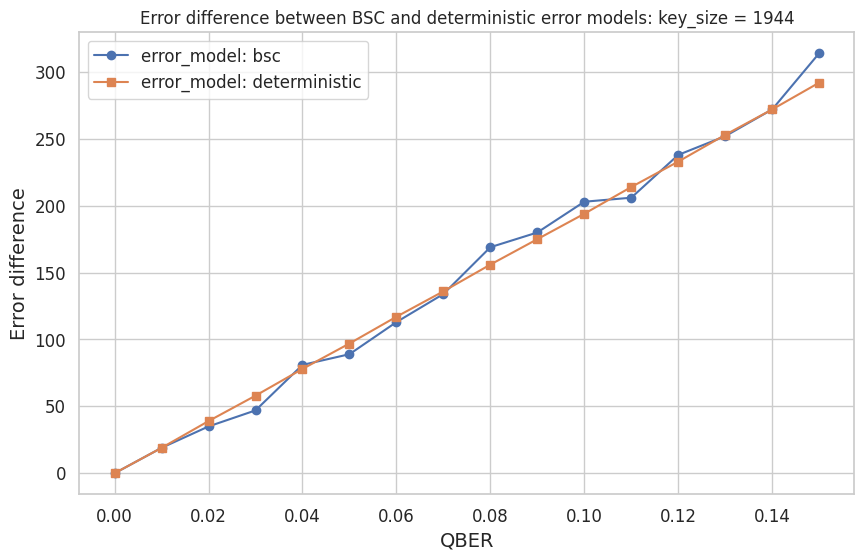

In [ ]:
plot_qber_error_difference(n=1944)

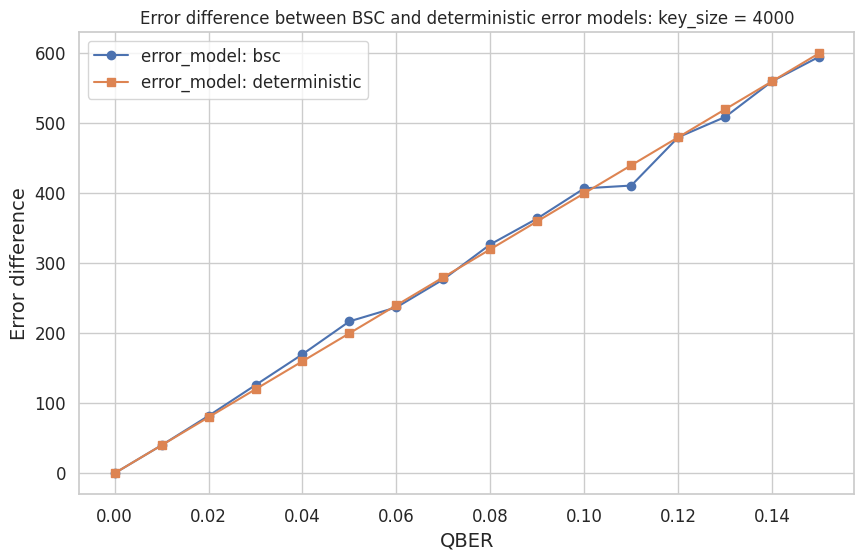

In [ ]:
plot_qber_error_difference(n=4000)

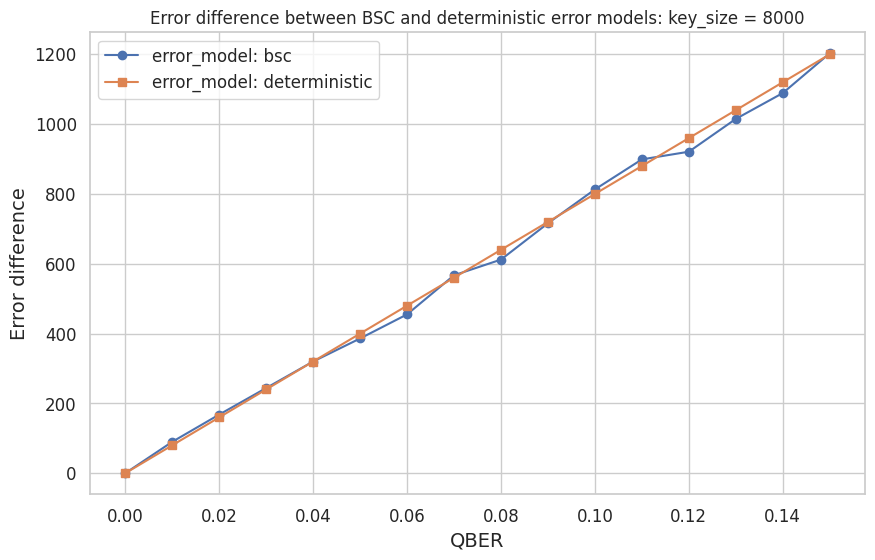

In [ ]:
plot_qber_error_difference(n=8000)

## Custom test error correction

In [ ]:
# Define a custom function to test error correction as specified in the assignment
def custom_test_ec(qber, R, codes, n, s_n, p_n, n_tries, f_start=1, show=1, discl_k=1, efficiency_metric='f_1', error_model='bsc'):
    k_n = n - s_n - p_n
    m = (1 - R) * n
    code_params = codes[(R, n)]
    s_y_joins = code_params['s_y_joins']
    y_s_joins = code_params['y_s_joins']
    punct_list = code_params['punct_list']
    syndrome_len = code_params['syndrome_len']
    p_n_max = len(punct_list)
    discl_n = int(round(n * (0.0280 - 0.02*R) * discl_k))
    qber_est = qber
    f_rslt = []
    com_iters_rslt = []
    n_incor = 0
    print("QBER = {}, R = {}, s_n = {}, p_n = {}, p_n_max = {}, discl_n = {}".format(qber, R, s_n, p_n, p_n_max, discl_n))
    for i in range(n_tries):
        print(i, end=': ')
        x = generate_key(n - s_n - p_n)
        if error_model == 'bsc':
          y = add_errors(x, qber)
        elif error_model == 'deterministic':
          y = add_errors_prec(x, qber)
        add_info, com_iters, x_dec, ver_check = perform_ec(x, y, s_y_joins, y_s_joins, qber_est, s_n, p_n, punct_list=punct_list, discl_n=discl_n, show=show)
        if efficiency_metric == 'f_1':
          f_cur = float(m - p_n + add_info) / (n - p_n - s_n) / h_b(qber)
        elif efficiency_metric == 'f_2':
          f_cur = (float(m - p_n + add_info) / (n - p_n - s_n)) - h_b(qber)
        f_rslt.append(f_cur)
        com_iters_rslt.append(com_iters)
        if not ver_check:
            n_incor += 1
    print('Mean efficiency:', np.mean(f_rslt),
          '\nMean additional communication rounds:', np.mean(com_iters_rslt),
          '\nEffective R:', (R - (s_n/n)) / (1 - s_n/n - p_n/n))
    return np.mean(f_rslt), np.mean(com_iters_rslt), R, s_n, p_n, p_n_max, k_n, discl_n, float(n_incor)/n_tries

In [ ]:
# Choose of the codes pool:
codes = codes_from_file(data_path + 'codes_1944.txt')
# codes = codes_from_file(data_path + 'codes_4000.txt')
n = 1944
# n = 4000

# Parameters
s_n = 0
p_n_list = [0, 50, 100, 150, 200]
R = 0.75
f_start = 1.0 # initial efficiency of decoding
qber_step = 0.01 # range of QBERs
n_tries = 10 # number of keys processed for each QBER value
qber_start = 0.02 # QBER starting point
qber_end = 0.03 # QBER end point
error_model = 'deterministic' # error model
efficiency_metric = 'f_1' # efficiency metric

f_name = 'ldpc_codes_{}_qber_start_{}_qber_end_{}_r_{}_sn_{}_pn_{}_em_{}.txt'.format(n, qber_start, qber_end, R, s_n, p_n_list, error_model) # file name for the output
output_filepath_ldpc = os.path.join(output_folder_ldpc, f_name)
file_output = open(output_filepath_ldpc, 'w')
file_output.write("code_n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER \n")

for qber in np.arange(qber_start, qber_end, qber_step):
    # Here we test the error correction for a given QBER
    # Output:
    # f_mean = mean efficiency of decoding,
    # com_iters_mean = mean number of communication iterations,
    # R = rate of the code,
    # s_n = number of shortened bits,
    # p_n = number of punctured bits,
    # p_n_max = maximal number of punctured bits,
    # k_n = n - s_n - p_n (effective bits of the key),
    # discl_n = number of disclosed bits,
    # FER = frame error rate
    for p in p_n_list:
      f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER = custom_test_ec(qber, R, codes, n, s_n, p, n_tries, f_start=f_start, show=1, discl_k=1, efficiency_metric=efficiency_metric, error_model=error_model)
      file_output.write('%d, %d, %8.4f, %14.8f, %14.8f, %14.8f, %10d, %10d, %10d, %14d, %10d, %14.8f \n' % (n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER))
file_output.close()

QBER = 0.02, R = 0.75, s_n = 0, p_n = 0, p_n_max = 227, discl_n = 25
0: done in 7 iterations, matched bits: 1944/1944
1: done in 4 iterations, matched bits: 1944/1944
2: done in 7 iterations, matched bits: 1944/1944
3: done in 6 iterations, matched bits: 1944/1944
4: done in 8 iterations, matched bits: 1944/1944
5: done in 4 iterations, matched bits: 1944/1944
6: done in 6 iterations, matched bits: 1944/1944
7: done in 8 iterations, matched bits: 1944/1944
8: done in 5 iterations, matched bits: 1944/1944
9: done in 3 iterations, matched bits: 1944/1944
Mean efficiency: 1.7675271566925788 
Mean additional communication rounds: 0.0 
Effective R: 0.75
QBER = 0.02, R = 0.75, s_n = 0, p_n = 50, p_n_max = 227, discl_n = 25
0: done in 9 iterations, matched bits: 1944/1944
1: done in 19 iterations, matched bits: 1944/1944
2: done in 8 iterations, matched bits: 1944/1944
3: done in 14 iterations, matched bits: 1944/1944
4: done in 6 iterations, matched bits: 1944/1944
5: done in 7 iterations, m

In [ ]:
def choose_codes(data_path, n):
    if n == 1944:
        codes_file = 'codes_1944.txt'
    elif n == 4000:
        codes_file = 'codes_4000.txt'
    else:
        raise ValueError("Unsupported value of n")
    return codes_from_file(data_path + codes_file)

In [ ]:
# Parameters
n_values = [1944, 4000] # list of codes
f_start = 1.0 # initial efficiency of decoding
qber_step = 0.01 # range of QBERs
n_tries = 10 # number of keys processed for each QBER value
qber_start = 0.02 # QBER starting point
qber_end = 0.03 # QBER end point
error_model = 'bsc' # error model
efficiency_metrics = ['f_1', 'f_2'] # list of efficiency metrics

for n in n_values:
    codes = choose_codes(data_path, n)
    # Computing the range of rates for given codes
    R_range = [code[0] for code in codes]
    print(f"R range for n = {n} is: {np.sort(R_range)}")
    for efficiency_metric in efficiency_metrics:
        f_name = 'ldpc_codes_{}_qber_start_{}_qber_end_{}_adaptive_r_sn_pn_eff_{}_em_{}.txt'.format(n, qber_start, qber_end, efficiency_metric, error_model)
        output_filepath_ldpc = os.path.join(output_folder_ldpc, f_name)
        file_output = open(output_filepath_ldpc, 'w')
        file_output.write("code_n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER \n")
        for qber in np.arange(qber_start, qber_end, qber_step):
            f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER = test_ec(qber, R_range, codes, n, n_tries, f_start=f_start, show=1, discl_k=1, efficiency_metric=efficiency_metric)
            print(f"QBER: {qber}, f_mean: {f_mean}, com_iters_mean: {com_iters_mean}, R: {R}, s_n: {s_n}, p_n: {p_n}, p_n_max: {p_n_max}, k_n: {k_n}, discl_n: {discl_n}, FER: {FER}")
            file_output.write('%d, %d, %8.4f, %14.8f, %14.8f, %14.8f, %10d, %10d, %10d, %14d, %10d, %14.8f \n' % (n, n_tries, qber, f_mean, com_iters_mean, R, s_n, p_n, p_n_max, k_n, discl_n, FER))
        file_output.close()

R range for n = 1944 is: [0.5    0.6667 0.75   0.8333]
QBER = 0.02, R = 0.8333, s_n = 0, p_n = 58, p_n_max = 152, discl_n = 22
0: done in 7 iterations, matched bits: 1944/1944
1: done in 5 iterations, matched bits: 1944/1944
2: done in 5 iterations, matched bits: 1944/1944
3: done in 8 iterations, matched bits: 1944/1944
4: done in 9 iterations, matched bits: 1944/1944
5: done in 7 iterations, matched bits: 1944/1944
6: done in 6 iterations, matched bits: 1944/1944
7: done in 29 iterations, matched bits: 1944/1944
8: done in 7 iterations, matched bits: 1944/1944
9: done in 23 iterations, matched bits: 1944/1944
Mean efficiency: 1.3272940598704697 
Mean additional communication rounds: 4.0 
Effective R: 0.8589264050901378
QBER: 0.02, f_mean: 1.3272940598704697, com_iters_mean: 4.0, R: 0.8333, s_n: 0, p_n: 58, p_n_max: 152, k_n: 1886, discl_n: 22, FER: 0.0
QBER = 0.02, R = 0.8333, s_n = 0, p_n = 58, p_n_max = 152, discl_n = 22
0: done in 9 iterations, matched bits: 1944/1944
1: done in 1

## Download LDPC results

In [ ]:
# Specify the folder path and zip filename
folder_path = "/content/results/ldpc/"
zip_filename = "ldpc_results.zip"
# Zip all files inside the folder
!zip -r {zip_filename} {folder_path}/*
# Download the zip file
gc_files.download(zip_filename)

updating: content/results/ldpc//default_output_1944.txt (deflated 60%)
updating: content/results/ldpc//ldpc_codes_1944_qber_start_0.02_qber_end_0.03_adaptive_r_sn_pn_eff_f_1_em_bsc.txt (deflated 42%)
updating: content/results/ldpc//ldpc_codes_1944_qber_start_0.02_qber_end_0.03_adaptive_r_sn_pn_eff_f_2_em_bsc.txt (deflated 43%)
updating: content/results/ldpc//ldpc_codes_1944_qber_start_0.02_qber_end_0.03_r_0.75_sn_0_pn_[0, 50, 100, 150, 200]_em_deterministic.txt (deflated 76%)
updating: content/results/ldpc//ldpc_codes_4000_qber_start_0.02_qber_end_0.03_adaptive_r_sn_pn_eff_f_1_em_bsc.txt (deflated 43%)
updating: content/results/ldpc//ldpc_codes_4000_qber_start_0.02_qber_end_0.03_adaptive_r_sn_pn_eff_f_2_em_bsc.txt (deflated 44%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cascade protocol implementation

In [ ]:
ALGORITHMS = {}

class Algorithm:
    """
    A Cascade algorithm.
    """

    def __init__(self, name, cascade_iterations, block_size_function, biconf_iterations,
                 biconf_error_free_streak, biconf_correct_complement, biconf_cascade,
                 sub_block_reuse, block_parity_inference):
        """
        Create a new Cascade algorithm.

        Params:
            name (str): A human-readable name that uniquely identifies the Cascade algorithm.
            cascade_iterations (int): The number of normal cascade iterations.
            block_size_function (function): A function that computes the block size given the
            estimated error rate, the key size, and the Cascade iteration number.
            biconf_iterations (int): The number of BICONF iterations to be run after the normal
            Cascade iterations are completed. 0 means don't run BICONF.
            biconf_error_free_streak (bool): If False, run a fixed number of BICONF iterations as
            indicated by biconf_iterations. If True, keep running BICONF until we see a streak
            of biconf_iterations error-free iterations.
            biconf_correct_complement (bool): If False, run BINARY only on the selected subset of
            bits. If True, run BINARY both on the selected subset of bits as well as the
            complementary set of bits.
            biconf_cascade (bool): Correct cascading errors during BICONF iterations?
            sub_block_reuse (bool): If False, consider only top-level blocks for cascading errors.
            If True, consider blocks of all sizes for cascading errors.
            block_parity_inference (bool): TODO
        """
        self.name = name
        self.cascade_iterations = cascade_iterations
        self.block_size_function = block_size_function
        self.biconf_iterations = biconf_iterations
        self.biconf_error_free_streak = biconf_error_free_streak
        self.biconf_correct_complement = biconf_correct_complement
        self.biconf_cascade = biconf_cascade
        self.sub_block_reuse = sub_block_reuse
        self.block_parity_inference = block_parity_inference
        ALGORITHMS[name] = self

def get_algorithm_by_name(name):
    """
    Get an algorithm object by name.

    Params:
        name (str): The name of the algorithm to be retrieved.

    Returns:
        The algorithm object corresponding to the given name, or None if no such algorithm exists.
    """
    return ALGORITHMS.get(name)

_MIN_ESTIMATED_BIT_ERROR_RATE = 0.00001

def _original_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    if iteration == 1:
        return math.ceil(0.73 / estimated_bit_error_rate)
    return 2 * _original_block_size_function(estimated_bit_error_rate, key_size, iteration - 1)

_ORIGINAL_ALGORITHM = Algorithm(name="original",
                                cascade_iterations=4,
                                block_size_function=_original_block_size_function,
                                biconf_iterations=0,
                                biconf_error_free_streak=False,
                                biconf_correct_complement=False,
                                biconf_cascade=False,
                                sub_block_reuse=False,
                                block_parity_inference=False)

def _biconf_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    if iteration == 1:
        return math.ceil(0.92 / estimated_bit_error_rate)
    return 3 * _biconf_block_size_function(estimated_bit_error_rate, key_size, iteration - 1)

_BICONF_ALGORITHM = Algorithm(name="biconf",
                              cascade_iterations=2,
                              block_size_function=_biconf_block_size_function,
                              biconf_iterations=10,
                              biconf_error_free_streak=True,
                              biconf_correct_complement=False,
                              biconf_cascade=False,
                              sub_block_reuse=False,
                              block_parity_inference=False)

def _yanetal_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    if iteration == 1:
        return math.ceil(0.80 / estimated_bit_error_rate)
    if iteration == 2:
        return 5 * _yanetal_block_size_function(estimated_bit_error_rate, key_size, iteration - 1)
    return key_size // 2

_YANETAL_ALGORITHM = Algorithm(name="yanetal",
                               cascade_iterations=10,
                               block_size_function=_yanetal_block_size_function,
                               biconf_iterations=0,
                               biconf_error_free_streak=False,
                               biconf_correct_complement=False,
                               biconf_cascade=False,
                               sub_block_reuse=False,
                               block_parity_inference=False)

def _option3456_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    if iteration == 1:
        return math.ceil(1.00 / estimated_bit_error_rate)
    if iteration == 2:
        return 2 * _option3456_block_size_function(estimated_bit_error_rate, key_size,
                                                   iteration - 1)
    return key_size // 2

_OPTION3_ALGORITHM = Algorithm(name="option3",
                               cascade_iterations=16,
                               block_size_function=_option3456_block_size_function,
                               biconf_iterations=0,
                               biconf_error_free_streak=False,
                               biconf_correct_complement=False,
                               biconf_cascade=False,
                               sub_block_reuse=False,
                               block_parity_inference=False)

_OPTION4_ALGORITHM = Algorithm(name="option4",
                               cascade_iterations=16,
                               block_size_function=_option3456_block_size_function,
                               biconf_iterations=0,
                               biconf_error_free_streak=False,
                               biconf_correct_complement=False,
                               biconf_cascade=False,
                               sub_block_reuse=True,
                               block_parity_inference=False)

def _option7_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    if iteration == 1:
        return 2 ** math.ceil(math.log2(1.00 / estimated_bit_error_rate))
    if iteration == 2:
        return 4 * _option7_block_size_function(estimated_bit_error_rate, key_size, iteration - 1)
    return key_size // 2

_OPTION7_ALGORITHM = Algorithm(name="option7",
                               cascade_iterations=14,
                               block_size_function=_option7_block_size_function,
                               biconf_iterations=0,
                               biconf_error_free_streak=False,
                               biconf_correct_complement=False,
                               biconf_cascade=False,
                               sub_block_reuse=True,
                               block_parity_inference=False)

def _option8_block_size_function(estimated_bit_error_rate, key_size, iteration):
    if estimated_bit_error_rate < _MIN_ESTIMATED_BIT_ERROR_RATE:
        estimated_bit_error_rate = _MIN_ESTIMATED_BIT_ERROR_RATE
    alpha = math.log2(1.00 / estimated_bit_error_rate) - 0.5
    if iteration == 1:
        return 2 ** math.ceil(alpha)
    if iteration == 2:
        return 2 ** math.ceil((alpha + 12.0) / 2.0)
    if iteration == 3:
        return 4096
    return key_size // 2

_OPTION8_ALGORITHM = Algorithm(name="option8",
                               cascade_iterations=14,
                               block_size_function=_option8_block_size_function,
                               biconf_iterations=0,
                               biconf_error_free_streak=False,
                               biconf_correct_complement=False,
                               biconf_cascade=False,
                               sub_block_reuse=True,
                               block_parity_inference=False)

In [ ]:
class Block:
    """
    A block is a contiguous subset of bits in a shuffled key.
    """
    ERRORS_EVEN = 0
    """The block contains an odd number of errors."""
    ERRORS_ODD = 1
    """The block contains an even number of errors."""
    ERRORS_UNKNOWN = None
    """We don't know whether the block contains an even or an odd number of errors."""

    def __init__(self, key, shuffle, start_index, end_index, parent_block):
        """
        Create a block, which is a contiguous subset of bits in a shuffled key.

        Args:
            key (Key): The key for which to create one single block that covers a subset of the key.
            shuffle (Shuffle): The shuffle to apply to the key before creating the block.
            start_index (int): The shuffle index, inclusive, at which the block starts. Must be in
                range [0, shuffle._size).
            end_index (int): The shuffle index, exclusive, at which the block end. Must be in range
                [0, shuffle._size]. The range must encompass at least 1 bit, i.e.
                end_index > start_index.
            parent_block (Block, optional): The parent block. None if there is no parent, i.e. if this is a
                top-level block.
        """
        # Store block attributes
        self._key = key
        self._shuffle = shuffle
        self._start_index = start_index
        self._end_index = end_index
        # Keep track of parent block. None if there is no parent, i.e. if this is a top-level block
        self._parent_block = parent_block
        # Keep track of left and right sub-block to avoid creating them more then once
        self._left_sub_block = None
        self._right_sub_block = None
        # Calculate the current parity for this block
        self._current_parity = shuffle.calculate_parity(key, start_index, end_index)
        # We don't yet know the correct parity for this block
        self._correct_parity = None

    @staticmethod
    def create_covering_blocks(key, shuffle, block_size):
        """
        Create a list of blocks of a given size that cover a given shuffled key.

        Args:
            key (Key): The key for which to create a list of block that collectively cover the
                entire key.
            shuffle (Shuffle): The shuffle to apply to the key before creating the blocks.
            block_size (int): The size of each block. Each block in the list, except for the last
                one, will be exactly this size. The last block may be smaller.

        Returns:
            A list of blocks that cover the shuffled key.
        """
        # Generate the blocks
        blocks = []
        remaining_bits = shuffle.get_size()
        start_index = 0
        while remaining_bits > 0:
            actual_block_size = min(block_size, remaining_bits)
            end_index = start_index + actual_block_size
            block = Block(key, shuffle, start_index, end_index, None)
            blocks.append(block)
            start_index += actual_block_size
            remaining_bits -= actual_block_size
        return blocks

    def __repr__(self):
        """
        Get the unambiguous string representation of the block.

        Returns:
            The unambiguous string representation of the block.
        """
        string = "Block:"
        for shuffle_index in range(self._start_index, self._end_index):
            key_index = self._shuffle.get_key_index(shuffle_index)
            key_bit = self._shuffle.get_bit(self._key, shuffle_index)
            string += f" {shuffle_index}->{key_index}={key_bit}"
        return string

    def __str__(self):
        """
        Get the human-readable string representation of the block.

        Returns:
            The human-readable string representation of the block.
        """
        string = ""
        for shuffle_index in range(self._start_index, self._end_index):
            string += str(self._shuffle.get_bit(self._key, shuffle_index))
        return string

    def __lt__(self, other):
        """
        Is this block "less than" the other block? This is needed to insert the blocks in a priority
        queue; for equal block sizes the priority queue want to order by increasing block size. We
        don't care about the order of blocks within a given block size, so we simply order based on
        the id().

        Returns:
            True if self < other, False otherwise.
        """
        return id(self) < id(other)

    def get_start_index(self):
        """
        Get the start index of the block, i.e. the shuffled key index for the first bit in the
        block.

        Returns:
            The start index.
        """
        return self._start_index

    def get_end_index(self):
        """
        Get the end index of the block, i.e. the shuffled key index for the first bit after the last
        bit in the block.

        Returns:
            The end index.
        """
        return self._end_index

    def get_shuffle(self):
        """
        Get the shuffle for this block.

        Returns:
            The shuffle for this block.
        """
        return self._shuffle

    def get_size(self):
        """
        Get the size of the block in bits.

        Returns:
            The size of the block in bits.
        """
        return self._end_index - self._start_index

    def get_key_indexes(self):
        """
        Get a list of key indexes for this block.

        Returns:
            The key indexes for this block (the ordering of the list is undefined; in particular
            don't assume that the key indexes are in increasing order.)
        """
        key_indexes = []
        for shuffle_index in range(self._start_index, self._end_index):
            key_index = self._shuffle.get_key_index(shuffle_index)
            key_indexes.append(key_index)
        return key_indexes

    def get_current_parity(self):
        """
        Get the current parity of the block.

        Returns:
            The current parity (0 or 1) of the block.
        """
        return self._current_parity

    def get_correct_parity(self):
        """
        Get the correct parity of the block, if we know it.

        Returns:
            The current parity (0 or 1) of the block, or None if we don't know it.
        """
        return self._correct_parity

    def set_correct_parity(self, correct_parity):
        """
        Set the correct parity of the block.

        Params:
            correct_parity (int): The current parity (0 or 1).
        """
        self._correct_parity = correct_parity

    def is_top_block(self):
        """
        Is this block a top-level block?

        Returns:
            True if the block was created by splitting a shuffled key into blocks. False if the
            block was created by splitting a block into sub-blocks.
        """
        return self._parent_block is None

    def get_parent_block(self):
        """
        Return the parent block of this block, if it has one.

        Returns:
            The parent block, or None if there is no parent block.
        """
        return self._parent_block

    def get_left_sub_block(self):
        """
        Return the left sub-block of this block, if it has one.

        Returns:
            The left sub-block, or None if there is no left sub-block.
        """
        return self._left_sub_block

    def create_left_sub_block(self):
        """
        Create the left sub-block of this block. If the block has an odd size, the left sub-block
        will be one bit larger than the right sub-block. The block must be at least 2 bits in size.

        Returns:
            The left sub-block.
        """
        middle_index = self._start_index + (self._end_index - self._start_index + 1) // 2
        self._left_sub_block = Block(self._key, self._shuffle, self._start_index, middle_index,
                                     self)
        return self._left_sub_block

    def get_right_sub_block(self):
        """
        Return the right sub-block of this block, if it has one.

        Returns:
            The right sub-block, or None if there is no right sub-block.
        """
        return self._right_sub_block

    def create_right_sub_block(self):
        """
        Create the right sub-block of this block. If the block has an odd size, the left sub-block
        will be one bit larger than the right sub-block. The block must be at least 2 bits in size.

        Returns:
            The right sub-block.
        """
        middle_index = self._start_index + (self._end_index - self._start_index + 1) // 2
        self._right_sub_block = Block(self._key, self._shuffle, middle_index, self._end_index, self)
        return self._right_sub_block

    def get_error_parity(self):
        """
        Does this block have an odd or an even number of errors?

        Returns:
            * ERRORS_ODD = The block contains an odd number of errors.
            * ERRORS_EVEN = The block contains an even number of errors.
            * ERRORS_UNKNOWN = We don't yet know whether the block contains an odd or even number of
              errors because we have not yet asked what the parity of the original key (without
              noise) is.
        """
        if self._correct_parity is None:
            return Block.ERRORS_UNKNOWN
        if self._current_parity == self._correct_parity:
            return Block.ERRORS_EVEN
        return Block.ERRORS_ODD

    def get_key_index(self, shuffle_index):
        """
        The the key index that corresponds to a given shuffle index.

        Params:
            shuffle_index: The shuffle index.

        Returns:
            The key index.
        """
        return self._shuffle.get_key_index(shuffle_index)

    def flip_bit(self, flipped_shuffle_index):
        """
        Flip a bit in the block.

        Params:
            flipped_shuffle_index: The shuffle index of the bit to flip.
        """
        self._shuffle.flip_bit(self._key, flipped_shuffle_index)

    def flip_parity(self):
        """
        Flip the current parity of this block. This is needed when a single bit in the block is
        flipped as a result of a single bit error correction.
        """
        self._current_parity = 1 - self._current_parity

In [ ]:
class Key:
    """
    A key that the Cascade protocol reconciles.
    """
    _random = random.Random()
    ERROR_METHOD_BERNOULLI = "bernoulli"
    ERROR_METHOD_EXACT = "exact"
    ERROR_METHODS = [ERROR_METHOD_BERNOULLI, ERROR_METHOD_EXACT]

    def __init__(self, s: str=None):
        """
        Create a key from string of 0, 1s.
        """
        self._size = 0
        self._bits = {}  # Bits are stored as dictionary, indexed by index [0..size), value 0 or 1
        if s is not None:
            self._size = len(s)
            for i in range(len(s)):
                if s[i] not in ['0', '1']:
                    raise ValueError('Only 0s and 1s are possible in the input string')
                self._bits[i] = int(s[i])

    @staticmethod
    def create_random_key(size):
        """
        Create an random key.

        Args:
            size (int): The size of the key in bits. Must be >= 0.

        Returns:
            A random key of the specified size.
        """
        key = Key()
        key._size = size
        for i in range(size):
            key._bits[i] = Key._random.randint(0, 1)
        return key

    def __repr__(self):
        """
        Get the unambiguous string representation of the key.

        Returns:
            The unambiguous string representation of the key.
        """
        return "Key: " + self.__str__()

    def __str__(self):
        """
        Get the human-readable string representation of the key.

        Returns:
            The human-readable string representation of the key.
        """
        string = ""
        for i in range(self._size):
            string += str(self._bits[i])
        return string

    @staticmethod
    def set_random_seed(seed):
        """
        Set the seed for the isolated random number generated that is used only in the key
        module and nowhere else. If two applications set the seed to the same value, the key
        module produces the exact same sequence of random keys. This is used to make experiments
        reproducible.

        Args:
            seed (int): The seed value for the random number generator which is isolated to the
                key module.
        """
        Key._random = random.Random(seed)

    def get_size(self):
        """
        Get the size of the key in bits.

        Returns:
            The size of the key in bits.
        """
        return self._size

    def get_bit(self, index):
        """
        Get the value of the key bit at a given index.

        Args:
            index (int): The index of the bit. Index must be in range [0, key.size).

        Returns:
            The value (0 or 1) of the key bit at the given index.
        """
        return self._bits[index]

    def set_bit(self, index, value):
        """
        Set the value of the key bit at a given index.

        Args:
            index (int): The index of the bit. Index must be in range [0, key.size).
            value (int): The new value of the bit. Must be 0 or 1.
        """
        self._bits[index] = value

    def flip_bit(self, index):
        """
        Flip the value of the key bit at a given index (0 to 1, and vice versa).

        Args:
            index (int): The index of the bit. Index must be in range [0, key.size).
        """
        self._bits[index] = 1 - self._bits[index]

    def copy(self, error_rate, error_method):
        """
        Copy a key and optionally apply noise.

        Args:
            error_rate (float): The requested error rate.
            error_method (str): The method for choosing errors. Must be one of the error methods in
                ERROR_METHODS.

        Returns:
            A new Key instance, which is a copy of this key, with noise applied.
        """
        key = Key()
        key._size = self._size
        key._bits = cp.deepcopy(self._bits)
        if error_method == self.ERROR_METHOD_EXACT:
            error_count = round(error_rate * self._size)
            bits_to_flip = Key._random.sample(self._bits.keys(), error_count)
            for index in bits_to_flip:
                key._bits[index] = 1 - key._bits[index]
        if error_method == self.ERROR_METHOD_BERNOULLI:
            for index in self._bits.keys():
                if Key._random.random() <= error_rate:
                    key._bits[index] = 1 - key._bits[index]
        return key

    def difference(self, other_key):
        """
        Return the number of bits that are different between this key and the other_key (also known
        as the Hamming distance).

        Args:
            other_key (Key): The other key that this key has to be compared with. Must be the same
                size as this key.

        Returns:
            The number of bits that are different between this key and the other key.
        """
        difference = 0
        for i in range(self._size):
            if self._bits[i] != other_key._bits[i]:
                difference += 1
        return difference

In [ ]:
class Shuffle:
    """
    A shuffling (i.e. re-ordering) of the bits in a key.
    """
    _shuffle_seed_random_generator = random.Random()
    SHUFFLE_KEEP_SAME = 0
    """Do not shuffle the bits in the key."""
    SHUFFLE_RANDOM = 1
    """Randomly shuffle the bits in the key."""
    _MAX_KEY_SIZE = 1_000_000_000
    _MAX_ALGORITHM = 100
    _MAX_SHUFFLE_SEED = 1_000_000_000_000

    def __init__(self, size, algorithm, shuffle_seed=None):
        """
        Create a shuffle. A shuffle represents a permutation of the bits in a key. The shuffle
        can be random or deterministic depending on the shuffle algorithm. A Shuffle object is
        de-coupled from the Key objects: the same Shuffle object can be applied to multiple
        different Key objects, to permute (shuffle) the bits in those different keys according to
        the same pattern.

        Args:
            size (int): The size of the shuffle, i.e. the number of bits in the keys that this
                shuffle will be applied to. Must be >= 0 (i.e. empty shuffles are allowed).
            algorithm (int): The algorithm for generating the shuffle pattern:
                SHUFFLE_KEEP_SAME: Do not shuffle the key (keep the key bits in the original order).
                SHUFFLE_RANDOM: Randomly shuffle the key.
            shuffle_seed (None or int): The seed value for the isolated shuffle random number
                generator that is used to generate the shuffling permutation. If shuffle_seed is
                None, then a random shuffle_seed value will be generated.
        """
        self._size = size
        self._shuffle_index_to_key_index = {}
        for shuffle_index in range(0, size):
            self._shuffle_index_to_key_index[shuffle_index] = shuffle_index
        if algorithm == self.SHUFFLE_RANDOM:
            if shuffle_seed is None:
                shuffle_seed = \
                    Shuffle._shuffle_seed_random_generator.randint(1, Shuffle._MAX_SHUFFLE_SEED - 1)
            shuffle_random_generator = random.Random(shuffle_seed)
            random.shuffle(self._shuffle_index_to_key_index, shuffle_random_generator.random)
        else:
            shuffle_seed = 0
        self._identifier = Shuffle._encode_identifier(size, algorithm, shuffle_seed)

    @staticmethod
    def create_shuffle_from_identifier(identifier):
        """
        Create a shuffle object from a shuffle identifier.

        Alice and Bob need to agree on how to shuffle the bits in each pass. Bob could send complete
        shuffle objects to Alice, but that would be expensive because shuffle objects are large.
        Instead, Bob sends a short shuffle identifier from Alice from which Alice can reconstruct
        the shuffle object.

        Args:
            identifier (int): The shuffle identifier.
        """
        (size, algorithm, shuffle_seed) = Shuffle._decode_identifier(identifier)
        shuffle = Shuffle(size, algorithm, shuffle_seed)
        return shuffle

    @staticmethod
    def _encode_identifier(size, algorithm, shuffle_seed):
        identifier = shuffle_seed
        identifier *= Shuffle._MAX_ALGORITHM
        identifier += algorithm
        identifier *= Shuffle._MAX_KEY_SIZE
        identifier += size
        return identifier

    @staticmethod
    def _decode_identifier(identifier):
        size = identifier % Shuffle._MAX_KEY_SIZE
        identifier //= Shuffle._MAX_KEY_SIZE
        algorithm = identifier % Shuffle._MAX_ALGORITHM
        identifier //= Shuffle._MAX_ALGORITHM
        shuffle_seed = identifier
        return size, algorithm, shuffle_seed

    def __repr__(self):
        """
        Get the unambiguous string representation of the shuffle.

        Returns:
            The unambiguous string representation of the shuffle.

        Example:
            >> shuffle.__repr__()
            'Shuffle: 0->3 1->1 2->2 3->0 4->4 5->5'
        """
        return "Shuffle: " + self.__str__()

    def __str__(self):
        """
        Get the human-readable string representation of the shuffle.

        Returns:
            The human-readable string representation of the shuffle.

        Example:
            >> shuffle.__str__()
            '0->3 1->1 2->2 3->0 4->4 5->5'
        """
        string = ""
        for shuffle_index in range(self._size):
            key_index = self._shuffle_index_to_key_index[shuffle_index]
            if string:
                string += " "
            string += f"{shuffle_index}->{key_index}"
        return string

    @staticmethod
    def set_random_seed(seed):
        """
        Set the seed for the isolated random number generated that is used only in the shuffle
        module and nowhere else. If two applications set the seed to the same value, the shuffle
        module produces the exact same sequence of shuffles. This is used to make experiments
        reproducible.

        Args:
            seed (int): The seed value for the random number generator which is isolated to the
                shuffle module.
        """
        Shuffle._shuffle_seed_random_generator = random.Random(seed)

    def get_size(self):
        """
        Get the size of the shuffle in bits.

        Returns:
            The size of the shuffle in bits.
        """
        return self._size

    def get_identifier(self):
        """
        Get the shuffle identifier.

        Returns:
            The shuffle identifier.
        """
        return self._identifier

    def get_key_index(self, shuffle_index):
        """
        Get the key index that a given shuffle index is mapped to.

        Args:
            shuffle_index (int): The shuffle index of the bit. Index must be in range
                [0, shuffle._size).

        Returns:
            The key index.
        """
        return self._shuffle_index_to_key_index[shuffle_index]

    def get_bit(self, key, shuffle_index):
        """
        Get a bit from a shuffled key.

        Args:
            key (Key): The key. We first shuffle this key according to this shuffle pattern and
                then retrieve the bit at shuffle_index in the shuffled key. The size of the key
                must be equal to the size of this shuffle.
            shuffle_index (int): The index of the bit in the shuffled key. The index must be in
                range [0, shuffle.size).

        Returns:
            The value (0 or 1) of the shuffled key bit at the given index.
        """
        key_index = self._shuffle_index_to_key_index[shuffle_index]
        return key.get_bit(key_index)

    def set_bit(self, key, shuffle_index, value):
        """
        Set a bit in a shuffled key to a given value.

        Args:
            key (Key): The key. We first shuffle this key according to this shuffle pattern and
                then set the bit at shuffle_index in the shuffled key to the given value. The size
                of the key must be equal to the size of this shuffle.
            shuffle_index (int): The index of the bit in the shuffled key. The index must be in
                range [0, shuffle.size).
            value (int): The new value of the bit. Must be 0 or 1.
        """
        key_index = self._shuffle_index_to_key_index[shuffle_index]
        key.set_bit(key_index, value)

    def flip_bit(self, key, shuffle_index):
        """
        Flip a bit in a shuffled key (flip 0 to 1 and vice versa).

        Args:
            key (Key): The key. We first shuffle this key according to this shuffle pattern and
                then flip the bit at shuffle_index in the shuffled key. The size of the key must be
                equal to the size of this shuffle.
            shuffle_index (int): The index of the bit in the shuffled key. The index must be in
                range [0, shuffle.size).
        """
        key_index = self._shuffle_index_to_key_index[shuffle_index]
        key.flip_bit(key_index)

    def calculate_parity(self, key, shuffle_start_index, shuffle_end_index):
        """
        Calculate the parity of a contiguous sub-range of bits in a shuffled key.

        Args:
            key (Key): The key for which to calculate the parity after shuffling it.
            shuffle_start_index (int): The index of the first bit (inclusive) in the range of
                bits in the shuffled key over which to calculate the parity.
            shuffle_end_index (int): The index of the last bit (exclusive) in the range of
                bits in the shuffled key over which to calculate the parity.

        Returns:
            The parity of the contiguous sub-range of bits in the shuffled key.
        """
        parity = 0
        for shuffle_index in range(shuffle_start_index, shuffle_end_index):
            key_index = self._shuffle_index_to_key_index[shuffle_index]
            if key.get_bit(key_index):
                parity = 1 - parity
        return parity

In [ ]:
class ClassicalChannel(ABC):
    """
    An abstract base class that abstracts the interactions that Bob has with Alice over the
    classical channel.
    """
    @abstractmethod
    def start_reconciliation(self):
        """
        Bob tells Alice that he is starting a new Cascade reconciliation.
        """
    @abstractmethod
    def end_reconciliation(self):
        """
        Bob tells Alice that he is finished with a Cascade reconciliation.
        """
    @abstractmethod
    def ask_parities(self, blocks):
        """
        Bob asks Alice to compute the parities for a list of blocks.
        Params:
            blocks (list): A list of blocks for which the ask the parities.

        Returns:
            parities (list): A list of parities, where each parity is an int value 0 or 1. The list
            of parities must be in the same order as the list of blocks.
        """

In [ ]:
class MockClassicalChannel(ClassicalChannel):
    """
    A mock concrete implementation of the ClassicalChannel base class, which is used for the
    experiments.
    """
    def __init__(self, correct_key):
        self._correct_key = correct_key
        self._id_to_shuffle = {}
        self._reconciliation_started = False

    def start_reconciliation(self):
        self._reconciliation_started = True

    def end_reconciliation(self):
        self._reconciliation_started = False
        self._id_to_shuffle = {}

    def ask_parities(self, blocks):
        parities = []
        for block in blocks:
            shuffle = block.get_shuffle()
            start_index = block.get_start_index()
            end_index = block.get_end_index()
            parity = shuffle.calculate_parity(self._correct_key, start_index, end_index)
            parities.append(parity)
        return parities

In [ ]:
class Stats:
    """
    Stats of a single reconciliation.
    """
    def __init__(self):
        """
        Create a new stats block with all counters initialized to zero.
        """
        self.elapsed_process_time = None
        self.elapsed_real_time = None
        self.normal_iterations = 0
        self.biconf_iterations = 0
        self.ask_parity_messages = 0
        self.ask_parity_blocks = 0
        self.ask_parity_bits = 0
        self.reply_parity_bits = 0
        self.efficiency_f1 = 0
        self.efficiency_f2 = 0
        self.realistic_efficiency = 0
        self.infer_parity_blocks = 0

In [ ]:
class Reconciliation:
    """
    A single information reconciliation exchange between a client (Bob) and a server (Alice).
    """

    def __init__(self, algorithm_name, classical_channel, noisy_key, estimated_bit_error_rate):
        """
        Create a Cascade reconciliation.

        Args:
            algorithm_name (str): The name of the Cascade algorithm.
            classical_channel (subclass of ClassicalChannel): The classical channel over which
                Bob communicates with Alice.
            noisy_key (Key): The noisy key as Bob received it from Alice that needs to be
                reconciliated.
            estimated_bit_error_rate (float): The estimated bit error rate in the noisy key.
        """
        # Store the arguments
        self._classical_channel = classical_channel
        self._algorithm = get_algorithm_by_name(algorithm_name)
        assert self._algorithm is not None
        self._estimated_bit_error_rate = estimated_bit_error_rate
        self._noisy_key = noisy_key
        self._reconciled_key = None
        # Map key indexes to blocks
        self._key_index_to_blocks = {}
        # Keep track of statistics
        self.stats = Stats()
        # A set of blocks that are suspected to contain an error, pending to be corrected later.
        # These are stored as a priority queue with items (block.size, block) so that we can correct
        # the pending blocks in order of shortest block first
        self._pending_try_correct = []
        # A set of blocks for which we have to ask Alice for the correct parity. To minimize the
        # number of message that Bob sends to Alice (i.e. the number of channel uses), we queue up
        # these pending parity questions until we can make no more progress correcting errors. Then
        # we send a single message to Alice to ask all queued parity questions, and proceed once we
        # get the answers
        self._pending_ask_correct_parity = []

    def get_noisy_key(self):
        """
        Get the noisy key, as Bob received it from Alice, that needs to be reconciled.

        Returns:
            The noisy key.
        """
        return self._noisy_key

    def get_reconciled_key(self):
        """
        Get the reconciled key, i.e. the key from which the reconciliation process attempted to
        remove the errors. There is still a small but non-zero chance that the reconciled key
        still contains errors.

        Returns:
            The reconciled key. None if the reconciliation process was not yet run.
        """
        return self._reconciled_key

    def reconcile(self):
        """
        Run the Cascade algorithm to reconciliate our ("Bob's") noisy key with the server's
        ("Alice's") correct key.

        Returns:
            The reconciled key. There is still a small but non-zero chance that the corrected key
            still contains errors.
        """
        # Start measuring process and real time
        start_process_time = time.process_time()
        start_real_time = time.perf_counter()
        # Make a deep copy of the key, so that we continue to have access to the original noisy key
        self._reconciled_key = cp.deepcopy(self._noisy_key)
        # Inform Alice that we are starting a new reconciliation
        self._classical_channel.start_reconciliation()
        # Do as many normal Cascade iterations as demanded by this particular Cascade algorithm
        self._all_normal_cascade_iterations()
        # Do as many normal BICONF iterations as demanded by this particular Cascade algorithm
        self._all_biconf_iterations()
        # Inform Alice that we have finished the reconciliation
        self._classical_channel.end_reconciliation()
        # Compute elapsed time
        self.stats.elapsed_process_time = time.process_time() - start_process_time
        self.stats.elapsed_real_time = time.perf_counter() - start_real_time
        # Compute efficiencies
        self.stats.efficiency_f1 = self._compute_efficiency_f1(self.stats.ask_parity_blocks)
        realistic_reconciliation_bits = self.stats.ask_parity_bits + self.stats.reply_parity_bits
        self.stats.realistic_efficiency = self._compute_efficiency_f1(realistic_reconciliation_bits)
        self.stats.efficiency_f2 = self._compute_efficiency_f2(self.stats.ask_parity_blocks)
        # Return the probably, but not surely, corrected key
        return self._reconciled_key

    def _register_block_key_indexes(self, block):
        # For every key bit covered by the block, append the block to the list of blocks that depend
        # on that particular key bit
        for key_index in block.get_key_indexes():
            if key_index in self._key_index_to_blocks:
                self._key_index_to_blocks[key_index].append(block)
            else:
                self._key_index_to_blocks[key_index] = [block]

    def _get_blocks_containing_key_index(self, key_index):
        return self._key_index_to_blocks.get(key_index, [])

    def _correct_parity_is_known_or_can_be_inferred(self, block):
        # Is the parity of the block already known?
        if block.get_correct_parity() is not None:
            return True
        # Try to do a very limited type of inference, using only the parity of the parent block and
        # the sibling block
        # Cannot infer if there is no parent block
        parent_block = block.get_parent_block()
        if parent_block is None:
            return False
        # Cannot infer if there is no sibling block (yet)
        if parent_block.get_left_sub_block() == block:
            sibling_block = parent_block.get_right_sub_block()
        else:
            sibling_block = parent_block.get_left_sub_block()
        if sibling_block is None:
            return False
        # Cannot infer if the correct parity of the parent or sibling block are unknown
        correct_parent_parity = parent_block.get_correct_parity()
        if correct_parent_parity is None:
            return False
        correct_sibling_parity = sibling_block.get_correct_parity()
        if correct_sibling_parity is None:
            return False
        # We have everything we need. Infer the correct parity
        if correct_parent_parity == 1:
            correct_block_parity = 1 - correct_sibling_parity
        else:
            correct_block_parity = correct_sibling_parity
        block.set_correct_parity(correct_block_parity)
        self.stats.infer_parity_blocks += 1
        return True

    def _schedule_ask_correct_parity(self, block, correct_right_sibling):
        # Adding an item to the end (not the start!) of a list is an efficient O(1) operation
        entry = (block, correct_right_sibling)
        self._pending_ask_correct_parity.append(entry)

    def _have_pending_ask_correct_parity(self):
        return self._pending_ask_correct_parity != []

    @staticmethod
    def _bits_in_int(int_value):
        bits = 0
        while int_value != 0:
            bits += 1
            int_value //= 2
        if bits == 0:
            bits = 1
        return bits

    @staticmethod
    def _bits_in_block_ask_parity(block):
        shuffle_identifier = block.get_shuffle().get_identifier()
        shuffle_start_index = block.get_start_index()
        shuffle_end_index = block.get_end_index()
        return Reconciliation._bits_in_int(shuffle_identifier) + \
               Reconciliation._bits_in_int(shuffle_start_index) + \
               Reconciliation._bits_in_int(shuffle_end_index)

    def _service_pending_ask_correct_parity(self):
        if not self._pending_ask_correct_parity:
            return
        # Prepare the question for Alice, i.e. the list of shuffle ranges over which we want Alice
        # to compute the correct parity
        ask_parity_blocks = []
        for entry in self._pending_ask_correct_parity:
            (block, _correct_right_sibling) = entry
            ask_parity_blocks.append(block)
            self.stats.ask_parity_bits += self._bits_in_block_ask_parity(block)
        # "Send a message" to Alice to ask her to compute the correct parities for the list that
        # we prepared. For now, this is a synchronous blocking operations (i.e. we block here
        # until we get the answer from Alice)
        self.stats.ask_parity_messages += 1
        self.stats.ask_parity_blocks += len(ask_parity_blocks)
        correct_parities = self._classical_channel.ask_parities(ask_parity_blocks)
        # Process the answer from Alice. IMPORTANT: Alice is required to send the list of parities
        # in the exact same order as the ranges in the question; this allows us to zip
        for (correct_parity, entry) in zip(correct_parities, self._pending_ask_correct_parity):
            self.stats.reply_parity_bits += 1
            (block, correct_right_sibling) = entry
            block.set_correct_parity(correct_parity)
            self._schedule_try_correct(block, correct_right_sibling)
        # Clear the list of pending questions
        self._pending_ask_correct_parity = []

    def _schedule_try_correct(self, block, correct_right_sibling):
        # Push the error block onto the heap. It is pushed as a tuple (block.size, block) to allow
        # us to correct the error blocks in order of shortest blocks first.
        entry = (block, correct_right_sibling)
        heapq.heappush(self._pending_try_correct, (block.get_size(), entry))

    def _have_pending_try_correct(self):
        return self._pending_try_correct != []

    def _service_pending_try_correct(self, cascade):
        errors_corrected = 0
        while self._pending_try_correct:
            (_, entry) = heapq.heappop(self._pending_try_correct)
            (block, correct_right_sibling) = entry
            errors_corrected += self._try_correct(block, correct_right_sibling, cascade)
        return errors_corrected

    def _compute_efficiency_f1(self, reconciliation_bits):
        eps = self._estimated_bit_error_rate
        try:
            shannon_efficiency = -eps * math.log2(eps) - (1 - eps) * math.log2(1 - eps)
            key_size = self._noisy_key.get_size()
            efficiency = reconciliation_bits / (key_size * shannon_efficiency)
        except (ValueError, ZeroDivisionError):
            efficiency = None
        return efficiency

    def _compute_efficiency_f2(self, reconciliation_bits):
        eps = self._estimated_bit_error_rate
        try:
            shannon_efficiency = -eps * math.log2(eps) - (1 - eps) * math.log2(1 - eps)
            key_size = self._noisy_key.get_size()
            efficiency = (reconciliation_bits / (key_size)) - shannon_efficiency
        except (ValueError, ZeroDivisionError):
            efficiency = None
        return efficiency

    def _all_normal_cascade_iterations(self):
        for iteration_nr in range(1, self._algorithm.cascade_iterations + 1):
            self._one_normal_cascade_iteration(iteration_nr)

    def _one_normal_cascade_iteration(self, iteration_nr):
        self.stats.normal_iterations += 1
        # Determine the block size to be used for this iteration, using the rules for this
        # particular algorithm of the Cascade algorithm
        block_size = self._algorithm.block_size_function(self._estimated_bit_error_rate,
                                                         self._reconciled_key.get_size(),
                                                         iteration_nr)
        # In the first iteration, we don't shuffle the key. In all subsequent iterations we
        # shuffle the key, using a different random shuffling in each iteration
        if iteration_nr == 1:
            shuffle = Shuffle(self._reconciled_key.get_size(), Shuffle.SHUFFLE_KEEP_SAME)
        else:
            shuffle = Shuffle(self._reconciled_key.get_size(), Shuffle.SHUFFLE_RANDOM)
        # Split the shuffled key into blocks, using the block size that we chose
        blocks = Block.create_covering_blocks(self._reconciled_key, shuffle, block_size)
        # For each top-level covering block...
        for block in blocks:
            # Update the key index to block map
            self._register_block_key_indexes(block)
            # We won't be able to do anything with the top-level covering blocks until we know what
            # the correct parity it
            self._schedule_ask_correct_parity(block, False)
        # Service all pending correction attempts (including Cascaded ones) and ask parity
        # messages
        self._service_all_pending_work(True)

    def _service_all_pending_work(self, cascade):
        # Keep track of how many errors were actually corrected in this call
        errors_corrected = 0
        # Keep going while there is more work to do.
        while self._have_pending_try_correct() or self._have_pending_ask_correct_parity():
            # Attempt to correct all of blocks that are currently pending as needing a correction
            # attempt. If we don't know the correct parity of the block, we won't be able to finish
            # the attempted correction yet. In that case the block will end up on the "pending ask
            # parity" list
            errors_corrected += self._service_pending_try_correct(cascade)
            # Now, ask Alice for the correct parity of the blocks that ended up on the "ask parity
            # list" in the above loop. When we get the answer from Alice, we may discover that the
            # block as an odd number of errors, in which case we add it back to the "pending error
            # block" priority queue
            self._service_pending_ask_correct_parity()
        return errors_corrected

    def _all_biconf_iterations(self):
        # Do nothing if BICONF is disabled
        if not self._algorithm.biconf_iterations:
            return
        # If we are not cascading during BICONF, clear the key indexes to blocks map to avoid
        # wasting time keeping it up to date as correct blocks during the BICONF phase
        if not self._algorithm.biconf_cascade:
            self._key_index_to_blocks = {}
        # Do the required number of BICONF iterations, as determined by the protocol
        iterations_to_go = self._algorithm.biconf_iterations
        while iterations_to_go > 0:
            errors_corrected = self._one_biconf_iteration()
            if self._algorithm.biconf_error_free_streak and errors_corrected > 0:
                iterations_to_go = self._algorithm.biconf_iterations
            else:
                iterations_to_go -= 1

    def _one_biconf_iteration(self):
        self.stats.biconf_iterations += 1
        cascade = self._algorithm.biconf_cascade
        # Randomly select half of the bits in the key. This is exactly the same as doing a new
        # random shuffle of the key and selecting the first half of newly shuffled key
        key_size = self._reconciled_key.get_size()
        shuffle = Shuffle(key_size, Shuffle.SHUFFLE_RANDOM)
        mid_index = key_size // 2
        chosen_block = Block(self._reconciled_key, shuffle, 0, mid_index, None)
        if cascade:
            self._register_block_key_indexes(chosen_block)
        # Ask Alice what the correct parity of the chosen block is
        self._schedule_ask_correct_parity(chosen_block, False)
        # If the algorithm wants it, also ask Alice what the correct parity of the complementary
        # block is
        if self._algorithm.biconf_correct_complement:
            complement_block = Block(self._reconciled_key, shuffle, mid_index, key_size, None)
            if cascade:
                self._register_block_key_indexes(complement_block)
            self._schedule_ask_correct_parity(complement_block, False)
        # Service all pending correction attempts (potentially including Cascaded ones) and ask
        # parity messages
        errors_corrected = self._service_all_pending_work(cascade)
        return errors_corrected

    def _try_correct(self, block, correct_right_sibling, cascade):
        # If we don't know the correct parity of the block, we cannot make progress on this block
        # until Alice has told us what the correct parity is
        if not self._correct_parity_is_known_or_can_be_inferred(block):
            self._schedule_ask_correct_parity(block, correct_right_sibling)
            return 0
        # If there is an even number of errors in this block, we don't attempt to fix any errors
        # in this block. But if asked to do so, we will attempt to fix an error in the right
        # sibling block
        if block.get_error_parity() == Block.ERRORS_EVEN:
            if correct_right_sibling:
                return self._try_correct_right_sibling_block(block, cascade)
            return 0
        # If this block contains a single bit, we have finished the recursion and found an error.
        # Correct the error by flipping the key bit that corresponds to this block
        if block.get_size() == 1:
            self._flip_key_bit_corresponding_to_single_bit_block(block, cascade)
            return 1
        # If we get here, it means that there is an odd number of errors in this block and that
        # the block is bigger than 1 bit.
        # Recurse to try to correct an error in the left sub-block first, and if there is no error
        # there, in the right sub-block alternatively.
        left_sub_block = block.get_left_sub_block()
        if left_sub_block is None:
            left_sub_block = block.create_left_sub_block()
            self._register_block_key_indexes(left_sub_block)
        return self._try_correct(left_sub_block, True, cascade)

    def _try_correct_right_sibling_block(self, block, cascade):
        parent_block = block.get_parent_block()
        right_sibling_block = parent_block.get_right_sub_block()
        if right_sibling_block is None:
            right_sibling_block = parent_block.create_right_sub_block()
            self._register_block_key_indexes(right_sibling_block)
        return self._try_correct(right_sibling_block, False, cascade)

    def _flip_key_bit_corresponding_to_single_bit_block(self, block, cascade):
        flipped_shuffle_index = block.get_start_index()
        block.flip_bit(flipped_shuffle_index)
        # For every block that covers the key bit that was corrected...
        flipped_key_index = block.get_key_index(flipped_shuffle_index)
        for affected_block in self._get_blocks_containing_key_index(flipped_key_index):
            # Flip the parity of that block
            affected_block.flip_parity()
            # If asked to do cascading, do so for blocks with an odd number of errors
            if cascade and affected_block.get_error_parity() != Block.ERRORS_EVEN:
                # If sub_block_reuse is disabled, then only cascade top-level blocks
                if self._algorithm.sub_block_reuse or affected_block.is_top_block():
                    self._schedule_try_correct(affected_block, False)

In [ ]:
algorithm = "original"
key_sizes = [1944, 4000] # key sizes to test
qber_start = 0.02 # QBER starting point
qber_end = 0.17 # QBER end point
qber_step = 0.01 # range of QBERs
error_model = 'bsc' # error model

for n in key_sizes:
    f_name = 'cascade_n_{}_qber_start_{}_qber_end_{}_em_{}.txt'.format(n, qber_start, qber_end, error_model)
    output_filepath_cascade = os.path.join(output_folder_cascade, f_name)
    file_output = open(output_filepath_cascade, 'w')
    file_output.write('key_size, time, qber, cascade_iterations, asked_parity_bits, f_1, f_2\n')
    for qber in np.arange(qber_start, qber_end, qber_step):
        correct_key = Key.create_random_key(n)
        noisy_key = correct_key.copy(qber, 'exact')
        actual_bit_errors = correct_key.difference(noisy_key)
        actual_bit_error_rate = actual_bit_errors / n
        mock_classical_channel = MockClassicalChannel(correct_key)
        reconciliation = Reconciliation(algorithm, mock_classical_channel, noisy_key, qber)
        reconciliated_key = reconciliation.reconcile()
        remaining_bit_errors = correct_key.difference(reconciliated_key)
        remaining_bit_error_rate = remaining_bit_errors / n
        print((f'key_size: {n}, time: {reconciliation.stats.elapsed_process_time}, qber: {qber}, cascade_iterations: {reconciliation.stats.normal_iterations}, asked_parity_bits: {reconciliation.stats.ask_parity_bits}, f_1: {reconciliation.stats.efficiency_f1}, f_2: {reconciliation.stats.efficiency_f2}'))
        file_output.write(f'{n}, {reconciliation.stats.elapsed_process_time}, {qber}, {reconciliation.stats.normal_iterations}, {reconciliation.stats.ask_parity_bits}, {reconciliation.stats.efficiency_f1}, {reconciliation.stats.efficiency_f2}\n')
    file_output.close()

key_size: 1944, time: 0.01914882000002649, qber: 0.02, cascade_iterations: 4, asked_parity_bits: 16812, f_1: 1.1601670020266102, f_2: 0.02265410766394063
key_size: 1944, time: 0.021459871999979896, qber: 0.03, cascade_iterations: 4, asked_parity_bits: 23854, f_1: 1.135227652059781, f_2: 0.026287154514102823
key_size: 1944, time: 0.02183277699998598, qber: 0.039999999999999994, cascade_iterations: 4, asked_parity_bits: 31053, f_1: 1.1846730929464773, f_2: 0.04474484795462222
key_size: 1944, time: 0.024196211999992556, qber: 0.049999999999999996, cascade_iterations: 4, asked_parity_bits: 37381, f_1: 1.1836430559912492, f_2: 0.05259481243136893
key_size: 1944, time: 0.025536518999984992, qber: 0.06, cascade_iterations: 4, asked_parity_bits: 43850, f_1: 1.2096401923175457, f_2: 0.0686456158249476
key_size: 1944, time: 0.027216287999976885, qber: 0.06999999999999999, cascade_iterations: 4, asked_parity_bits: 52311, f_1: 1.2426977845497567, f_2: 0.08880885938784272
key_size: 1944, time: 0.02

## Download Cascade results

In [ ]:
# Specify the folder path and zip filename
folder_path = "/content/results/cascade/"
zip_filename = "cascade_results.zip"
# Zip all files inside the folder
!zip -r {zip_filename} {folder_path}/*
# Download the zip file
gc_files.download(zip_filename)

updating: content/results/cascade//cascade_n_1944_qber_start_0.02_qber_end_0.17_em_bsc.txt (deflated 57%)
updating: content/results/cascade//cascade_n_4000_qber_start_0.02_qber_end_0.17_em_bsc.txt (deflated 57%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot the results

In [ ]:
def plot_preliminary_results_efficiency(file_path, n=1944):
    sns.set(style="whitegrid")
    # Read the data from the txt file
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
    shortening_bits = np.unique(data[:, 6])
    puncturing_bits = np.unique(data[:, 7])
    plt.figure(figsize=(10, 6))
    for s_n in shortening_bits:
        for p_n in puncturing_bits:
            subset = data[(data[:, 6] == s_n) & (data[:, 7] == p_n)]
            label = f's_n: {int(s_n)}, p_n: {int(p_n)}'
            plt.plot(subset[:, 2], subset[:, 3], label=label)
    # Set labels and title
    plt.xlabel('QBER', fontsize=14)
    plt.ylabel('f_mean', fontsize=14)
    plt.title(f'QBER vs f_mean: s_n = np.arange(0, 200, 50), p_n = 0, n = {n}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    # Save the plot as PNG
    plt.savefig(f'ldpc_{n}_qber_vs_f_mean_plot_{14}.png')
    # Show legend
    plt.legend(fontsize=12)
    # Show the plot
    plt.show()

In [ ]:
def plot_preliminary_results_iterations(file_path, n=1944):
    sns.set(style="whitegrid")
    # Read the data from the txt file
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)
    shortening_bits = np.unique(data[:, 6])
    puncturing_bits = np.unique(data[:, 7])
    plt.figure(figsize=(10, 6))
    for s_n in shortening_bits:
        for p_n in puncturing_bits:
            subset = data[(data[:, 6] == s_n) & (data[:, 7] == p_n)]
            label = f's_n: {int(s_n)}, p_n: {int(p_n)}'
            plt.plot(subset[:, 2], subset[:, 4], label=label)
    # Set labels and title
    plt.xlabel('QBER', fontsize=14)
    plt.ylabel('com_iters_mean', fontsize=14)
    plt.title(f'QBER vs com_iters_mean: s_n = np.arange(0, 200, 50), p_n = 0, n = {n}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    # Save the plot as PNG
    plt.savefig(f'ldpc_{n}_qber_vs_com_iters_mean_plot_{14}.png')
    # Show legend
    plt.legend(fontsize=12)
    # Show the plot
    plt.show()

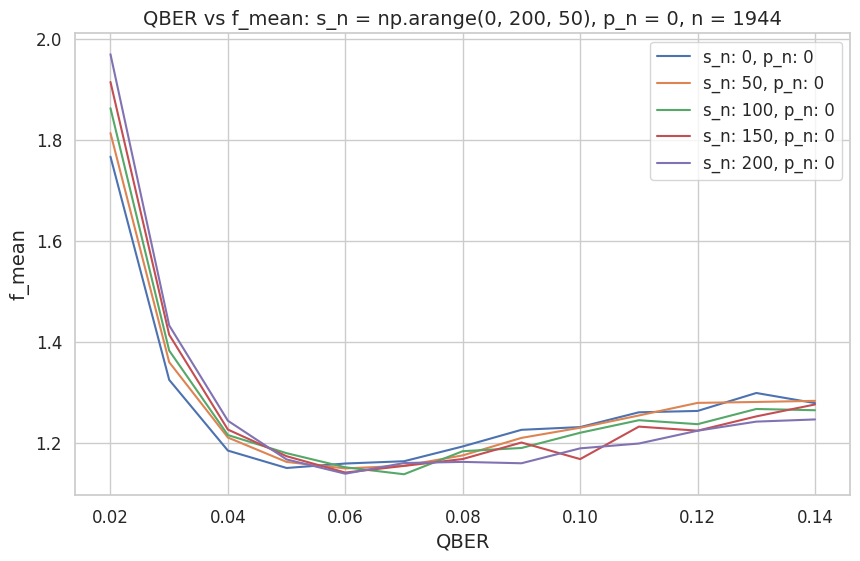

In [ ]:
plot_preliminary_results_efficiency('/content/ldpc_codes_1944_qber_start_0.02_qber_end_0.14_r_0.75_sn_[0, 50, 100, 150, 200]_pn_0_em_deterministic.txt', n=1944)

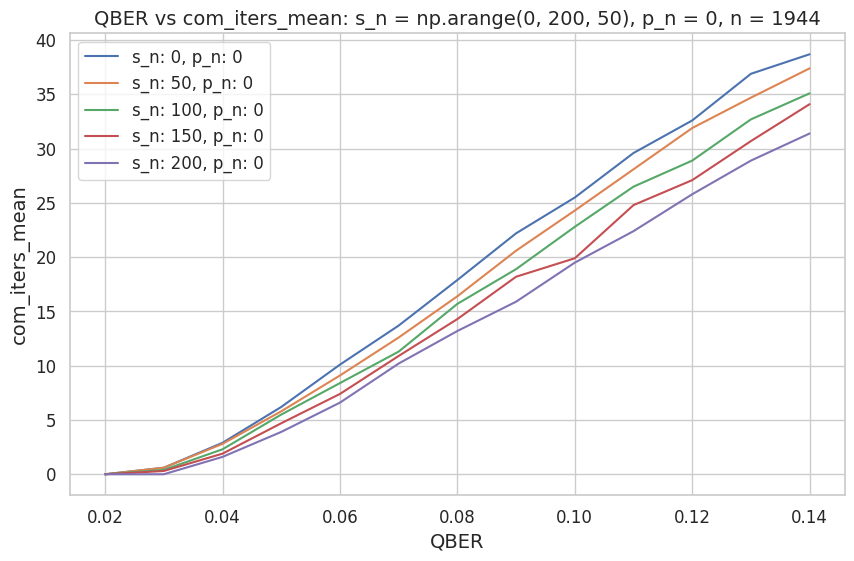

In [ ]:
plot_preliminary_results_iterations('/content/ldpc_codes_1944_qber_start_0.02_qber_end_0.14_r_0.75_sn_[0, 50, 100, 150, 200]_pn_0_em_deterministic.txt', n=1944)

In [ ]:
def plot_final_results(data_files, efficiency='f_1', n=1944):
    plt.rc('text', usetex=False)
    sns.set(style="whitegrid")
    qber_values_1 = []
    f_mean_values_1 = []
    qber_values_2 = []
    f_mean_values_2 = []
    # Read and process the first data file
    with open(data_files[0], 'r') as file_1:
        next(file_1)
        for line in file_1:
            columns = line.strip().split(',')
            qber_values_1.append(float(columns[2]))
            f_mean_values_1.append(float(columns[3]))
    # Read and process the second data file
    with open(data_files[1], 'r') as file_2:
        next(file_2)
        for line in file_2:
            columns = line.strip().split(',')
            qber_values_2.append(float(columns[2]))
            if efficiency == 'f_1':
              f_mean_values_2.append(float(columns[5]))
            elif efficiency == 'f_2':
              f_mean_values_2.append(float(columns[6]))
    # Plot both datasets on the same graph
    plt.figure(figsize=(10, 6))
    plt.plot(qber_values_1, f_mean_values_1, marker='o', linestyle='-', label='ldpc')
    plt.plot(qber_values_2, f_mean_values_2, marker='s', linestyle='-', label='cascade')
    plt.xlabel('QBER', fontsize=14)
    if efficiency == 'f_1':
      plt.axhline(y=1, color='black', linestyle='--', label='perfect_efficiency')
      plt.ylabel(r'$f_{1} = \lambda_{EC} \: / \: n \cdot h_{2}(Q)$', fontsize=14)
      plt.title(f'QBER vs $f_{1}$: n = {n}', fontsize=14)
      plt.ylim(bottom=0.98)
    elif efficiency == 'f_2':
      plt.ylabel(r'$f_{2} = \lambda_{EC} \: / \: n - h_{2}(Q)}$', fontsize=14)
      plt.title(f'QBER vs $f_{2}$: n = {n}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    # Save the plot as PNG
    plt.savefig(f'ldpc_cascade_{n}_qber_vs_{efficiency}_plot.png')
    # Show the plot
    plt.show()

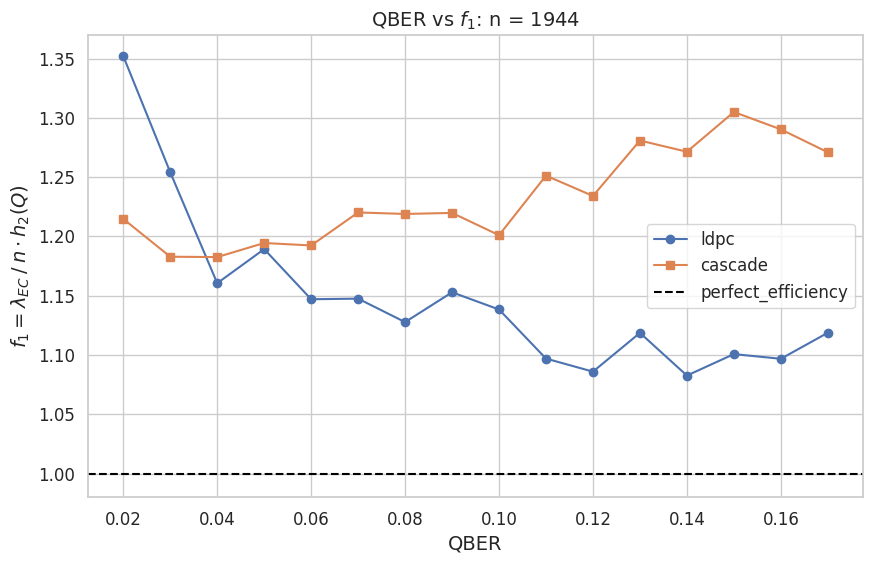

In [ ]:
file_path_1 = '/content/ldpc_codes_1944_qber_start_0.02_qber_end_0.17_adaptive_r_sn_pn_eff_f_1_em_bsc.txt'
file_path_2 = '/content/cascade_n_1944_qber_start_0.02_qber_end_0.17_em_bsc.txt'
plot_final_results([file_path_1, file_path_2], 'f_1', 1944)

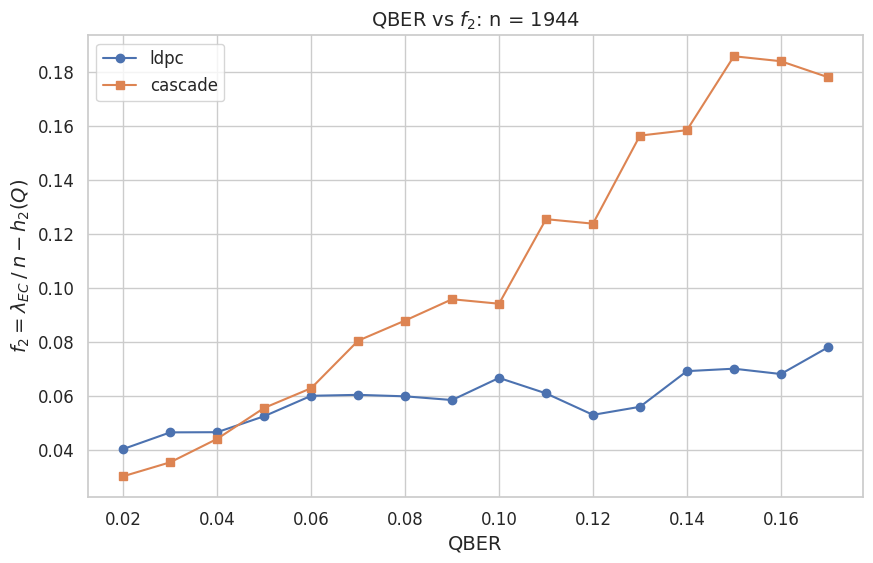

In [ ]:
file_path_1 = '/content/ldpc_codes_1944_qber_start_0.02_qber_end_0.17_adaptive_r_sn_pn_eff_f_2_em_bsc.txt'
file_path_2 = '/content/cascade_n_1944_qber_start_0.02_qber_end_0.17_em_bsc.txt'
plot_final_results([file_path_1, file_path_2], 'f_2', n=1944)

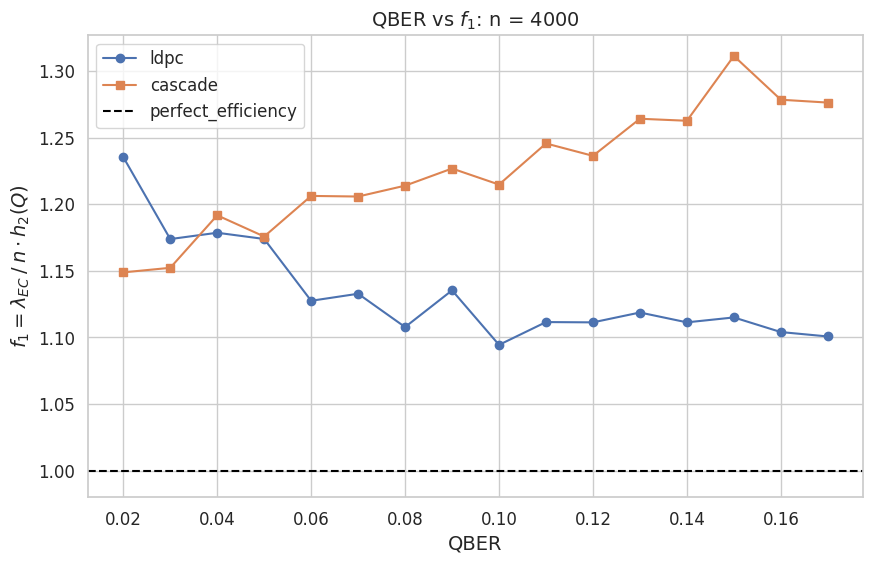

In [ ]:
file_path_1 = '/content/ldpc_codes_4000_qber_start_0.02_qber_end_0.17_adaptive_r_sn_pn_eff_f_1_em_bsc.txt'
file_path_2 = '/content/cascade_n_4000_qber_start_0.02_qber_end_0.17_em_bsc.txt'
plot_final_results([file_path_1, file_path_2], 'f_1', n=4000)

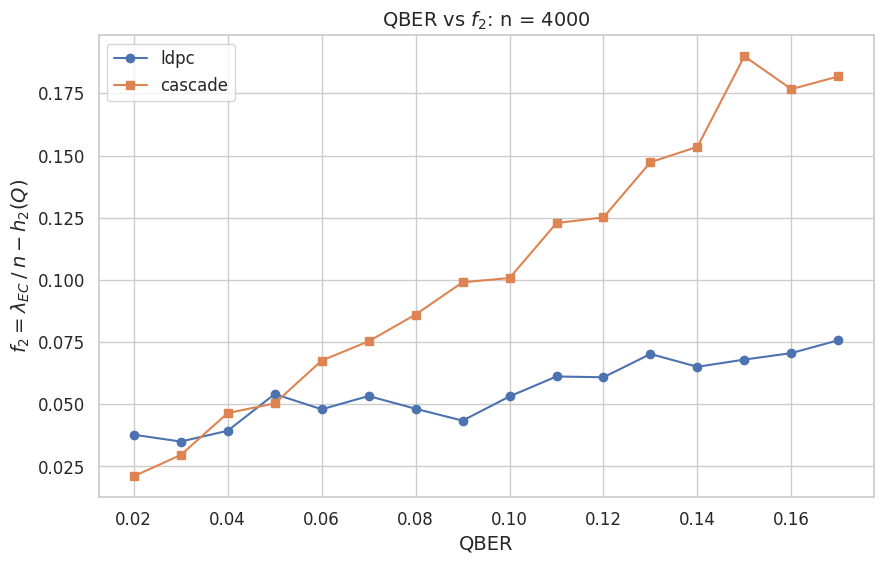

In [ ]:
file_path_1 = '/content/ldpc_codes_4000_qber_start_0.02_qber_end_0.17_adaptive_r_sn_pn_eff_f_2_em_bsc.txt'
file_path_2 = '/content/cascade_n_4000_qber_start_0.02_qber_end_0.17_em_bsc.txt'
plot_final_results([file_path_1, file_path_2], 'f_2', n=4000)